In [2]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"Pytorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Pytorch version: 1.13.0.dev20220530
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [4]:
import torch

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Create data and send it to the device
x = torch.rand(size=(3, 4)).to(device)
x



/Users/hemanthkumarak/Documents/python_work/pytorch_work/pytorch-test/env/lib/python3.8/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor([[0.2797, 0.9254, 0.8924, 0.9095],
        [0.6257, 0.8840, 0.9693, 0.9101],
        [0.5723, 0.2977, 0.2528, 0.4184]], device='mps:0')

In [86]:
# Setup hyperparameters
BATCH_SIZE = 32 # good for your health: https://twitter.com/ylecun/status/989610208497360896
IMAGE_SIZE = (224, 224) # (height, width) smaller images means faster computing 
NUM_EPOCHS = 3 # only run for a short period of time... we don't have all day
DATASET_NAME = "cifar10" # dataset to use (there are more in torchvision.datasets)
MACHINE = "Apple M1 Max" # change this depending on where you're runing the code
NUM_WORKERS = 2 # set number of cores to load data

In [6]:
from timeit import default_timer as timer

def print_train_time(start, end, device=None, machine=None):
    """Prints difference between start and end time.
    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
    Returns:
         float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    if device:
        print(f"\nTrain time on {machine} using PyTorch device {device}: {total_time: .3f} seconds\n")
    else:
        print(f"\nTrain time: {total_time: .3f} seconds\n")
    return round(total_time, 3)

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()
])

# Get Datasets

train_data = datasets.CIFAR10(root="data",
                             train=True,
                             transform=simple_transform,
                             download=True)

test_data = datasets.CIFAR10(root="data",
                            train=False,
                            transform=simple_transform,
                            download=True)

print(f"Number of training samples: {len(train_data)}, number of testing samples: {len(test_data)}")

# Create DataLoaders
train_dataloader = DataLoader(train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS,
                             pin_memory=True)


test_dataloader = DataLoader(test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            pin_memory=True)

train_dataloader, test_dataloader







Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000, number of testing samples: 10000


(<torch.utils.data.dataloader.DataLoader at 0x286eae7f0>,
 <torch.utils.data.dataloader.DataLoader at 0x287ca22e0>)

In [10]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [11]:
# Get class names
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [27]:
# Take in a Dataset as well as a list of class names
import random
from typing import List

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                         classes: List[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):
    
    # Adjust display if n is too high a value
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
        
    # Set random seed
    if seed:
        random.seed(seed)

    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # Setup plot
    plt.figure(figsize=(16,8))

    # Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust image tensor shape for plotting: 
            # [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")

        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = f"class: {classes[targ_label]}"


        plt.title(title)
                
            
            
            
            
            
            
            
            
            

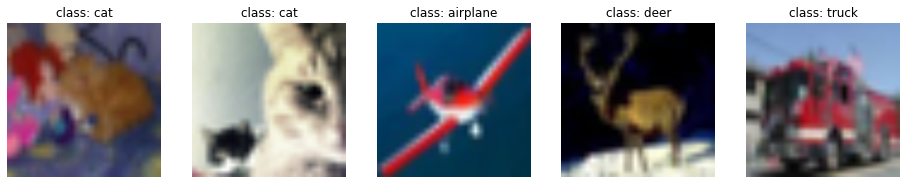

In [55]:
# Display random images
display_random_images(train_data,
                     n=5,
                     classes=class_names,
                     seed=None)

In [65]:
# TinyVGG architecture from CNN explainer website: https://poloclub.github.io/cnn-explainer

import torch
from torch import nn

class TinyVGG(nn.Module):
    """
        Creates the TinyVGG architecture.
        
        Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
        See te original architecture here: https://poloclub.github.io/cnn-explainer/
        
        Args:
        input_shape: An int indicatin number of input channels.
        hidden_units: An int indicating number of hidden units between layers.
        output_shape: An int indicating number of output units.
        
    """
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2,
                       stride=2)
        
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #nn.Linear(in_features=hidden_units*5*5, out_features=output_shape) #image shape 32x32
            nn.Linear(in_features=hidden_units*53*53, out_features=output_shape) #image shape 224x224
        )
        
    
    def forward(self, x: torch.Tensor):
#         print(x.shape)
#         x = self.conv_block_1(x)
#         print(x.shape)
#         x = self.conv_block_2(x)
#         print(x.shape)
#         x = self.classfier(x)
#         return(x)
        
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))








In [66]:
model = TinyVGG(input_shape=3,
               hidden_units=10,
               output_shape=3)

model(torch.randn(1, 3, 224, 224))

tensor([[ 0.0057,  0.0003, -0.0471]], grad_fn=<AddmmBackward0>)

In [85]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):
    
    # Put model into train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
        
        # Send data to target device
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        
#         X, y = X.to(device, non_blocking=True, memory_format=torch.channels_last), y.to(device, non_blocking=True)
#         X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        #3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        #5. Optimizer step
        optimizer.step()
        
        # Calculate and accumulaet accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
    

In [82]:
def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):
    
    # Put model in eval mode
    model.eval()
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            
#             X, y = X.to(device, non_blocking=True, memory_format=torch.channels_last), y.to(device, non_blocking=True)
#             X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels ==y).sum().item()/len(test_pred_labels))
        
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
    

In [88]:
from tqdm.auto import tqdm

#1. Take in varios params required for training and test steps

def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module,
         epochs: int,
         device: torch.device):
    
    print(f"[INFO] Training model: {model.__class__.__name__} on device: '{device}' for epochs: {epochs}...")
    
    #2. Create empty results disctionary
    results = {
                "train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": []
              }
    
    # 3. Loop through training and testing steps for a number of epochs
    
    for epoch in tqdm(range(epochs)):
        
        # Do eval before training to see if there are any errors
        test_loss, test_acc = test_step(
                                            model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            device=device
                                       )
        
        train_loss, train_acc = train_step(
                                            model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device
                                        )
        
        
        # 4. Print out what's happening
        print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f} | "
        )
        
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    
    # 6. Return the filled results at the end of the loop
    return results

In [89]:
# Set random seed
torch.manual_seed(42)

# Create device list
devices = ["cpu", "mps"]

for device in devices:
    
    # Recreate an instance of TinyVGG
    model = TinyVGG(
                        input_shape=3, #number of color channel (3 for RGB)
                        hidden_units=10,
                        output_shape=len(train_data.classes)
                   ).to(device)
        
    # Setup loss function and optiimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    
    # Start the timer
    from timeit import default_timer as timer
    start_time = timer()
    
    # Train model
    model_results = train(
                            model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=NUM_EPOCHS,
                            device=device
                        )
    
    # End the timer
    end_time = timer()
    
    # Print out timer and results
    total_train_time = print_train_time(
                                            start=start_time,
                                            end=end_time,
                                            device=device,
                                            machine=MACHINE
                                    )
    
    # Create results dict
    results = {
        "machine": MACHINE,
        "device": device,
        "dataset_name": DATASET_NAME,
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "image_size": IMAGE_SIZE[0],
        "num_train_samples": len(train_data),
        "num_test_samples": len(test_data),
        "total_train_time": round(total_train_time, 3),
        "time_per_epoch": round(total_train_time/NUM_EPOCHS, 3),
        "model": model.__class__.__name__
    }
    
    results_df = pd.DataFrame(results, index=[0])
    
    # Write CSV to file
    import os
    if not os.path.exists("results/"):
        os.makedirs("results/")
        
    results_df.to_csv(
                        f"results/{MACHINE.lower().replace(' ', '_')}_{device}_{DATASET_NAME}_image_size.csv",
                        index=False
                    )
    
    
    
    
    
    
    

[INFO] Training model: TinyVGG on device: 'cpu' for epochs: 3...


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9389 | train_acc: 0.3035 | test_loss: 2.3026 | test_acc: 0.1000 | 
Epoch: 2 | train_loss: 1.7645 | train_acc: 0.3786 | test_loss: 1.7947 | test_acc: 0.3656 | 
Epoch: 3 | train_loss: 1.7437 | train_acc: 0.3883 | test_loss: 1.7682 | test_acc: 0.3714 | 

Train time on Apple M1 Max using PyTorch device cpu:  1776.682 seconds

[INFO] Training model: TinyVGG on device: 'mps' for epochs: 3...


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0611 | train_acc: 0.2713 | test_loss: 2.3035 | test_acc: 0.1000 | 
Epoch: 2 | train_loss: 1.9633 | train_acc: 0.3017 | test_loss: 1.9973 | test_acc: 0.2910 | 
Epoch: 3 | train_loss: 1.9363 | train_acc: 0.3032 | test_loss: 1.9308 | test_acc: 0.3142 | 

Train time on Apple M1 Max using PyTorch device mps:  256.212 seconds



In [90]:
# Get CSV paths from results
from pathlib import Path
results_paths = list(Path("results").glob("*.csv"))

df_list = []
for path in results_paths:
    df_list.append(pd.read_csv(path))
results_df = pd.concat(df_list).reset_index(drop=True)
results_df

,machine,device,dataset_name,epochs,batch_size,image_size,num_train_samples,num_test_samples,total_train_time,time_per_epoch,model
0,Apple M1 Max,cpu,cifar10,3,32,224,50000,10000,1776.682,592.227,TinyVGG
1,Apple M1 Max,mps,cifar10,3,32,224,50000,10000,256.212,85.404,TinyVGG


Saving figure to 'results/TinyVGG_cifar10_benchmark_with_batch_size_32_image_size_224.png'


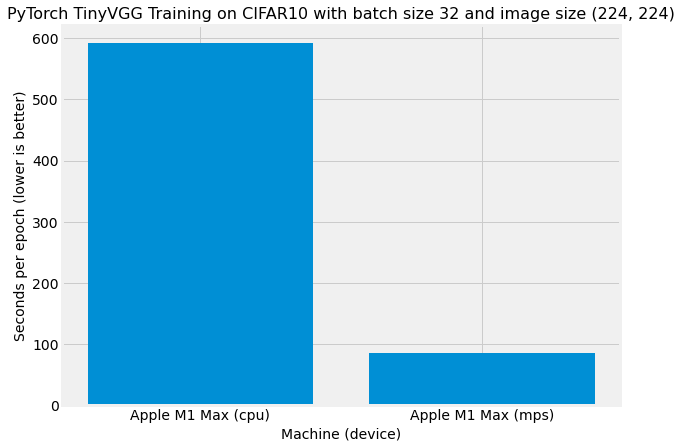

In [91]:
# Get names of devices
machine_and_device_list = [row[1][0] + " (" + row[1][1] + ")" for row in results_df[["machine", "device"]].iterrows()]

# Plot and save figure
plt.figure(figsize=(10, 7))
plt.style.use('fivethirtyeight')
plt.bar(machine_and_device_list, height=results_df.time_per_epoch)
plt.title(f"PyTorch TinyVGG Training on CIFAR10 with batch size {BATCH_SIZE} and image size {IMAGE_SIZE}", size=16)
plt.xlabel("Machine (device)", size=14)
plt.ylabel("Seconds per epoch (lower is better)", size=14);
save_path = f"results/{model.__class__.__name__}_{DATASET_NAME}_benchmark_with_batch_size_{BATCH_SIZE}_image_size_{IMAGE_SIZE[0]}.png"
print(f"Saving figure to '{save_path}'")
plt.savefig(save_path)